We consider a classical linear-quadratic-Gaussian (LQG) control problem in 1-D:
$$
d X_t=2 \sqrt{\lambda} \alpha_t d t+\sqrt{2} d W_t, X_0 = x
$$
with a control process $\left\{\alpha_t\right\}_{t \in[0, T]}$ with values in $\mathbb{R}^1$. The solution of the control problem is characterized by the value function
$$
v(0, x)=\min _{\alpha_t} \mathbb{E}\left[\int_0^T\alpha_t^2 \mathrm{~d} t+g\left(X_T\right) \mid X_0=x\right],
$$

with terminal cost function $g(x) = \ln \left(\left(1+\|x\|^2\right) / 2\right)$


The Hamilton-Jacobi-Bellman equation associated with the stochastic control problem is given by the nonlinear PDE
$$
\partial_t v(t, x)+\partial_{xx}v(t, x)+\min _\alpha\left\{2 \sqrt{\lambda} \alpha \cdot \partial_x v(t, x)+\alpha^2\right\}=0, \quad v(T, x)=g(x) .
$$



The minimum is attained at $\alpha =- \sqrt{\lambda} \partial_x u$, plugging back in, one obtain the desired semilinear PDE form:
$$
\partial_t v(t, x)+\partial_{xx}v(t, x) - 2 {\lambda}  (\partial_x v(t, x))^2 + \lambda\partial_x v(t,x)^2=0, 
$$


with 
$\\b(x) = -2 \lambda \partial_x v(t, x)$

$\sigma(x) = \sqrt{2}$

$f(t,x,y,z) =  \lambda z^2/\sigma^2$ 

Remark: $z = \sigma^{\prime} \partial_x v$

In [1]:
def g(x):
    terminal_func = torch.log(0.5 *(1+x**2)).flatten()
    return terminal_func

import math
def f(t,x,y,z):
    sigma = math.sqrt(2)
    running_cost = lamb * z**2/sigma**2
    return running_cost.flatten()


Discretize on $[0,1]$ with $dt =0.01$. Number of gradient updates = 1000. Number of simulations per step = $2^9$.

In [61]:
import numpy as np
import torch


t = torch.linspace(0,1,101,dtype = torch.float32)
dt = t[1]-t[0] 
# total updates for gradient descent
N_epoch = 500
# batch_size
N_MC = 2**8 #250 samplew
#Number of monte carlo simulationsat each time point.
BM_mat = torch.sqrt(dt) * np.random.normal(size = (N_MC,len(t)-1))
BM_mat = BM_mat.to(t.dtype)

Here, we create a list of Neural Networks 

${\mathcal{NN}}=\left(\mathcal{NN}_{u_0}, \mathcal{NN}_{\nabla u_0}, \mathcal{NN}_{\nabla u_1}, \ldots \mathcal{NN}_{\nabla v_{N-1}}\right)$ to approximate $\\v(0,x_0), x_0 \in \mathcal{D}$, $\sigma^{\prime} \partial_x v(0,x), \sigma^{\prime} \partial_x v(1,x),...,  \sigma^{\prime} \partial_x v(N-1,x)$ respectively.

In each gradient descent, we update all the $\mathcal{NN}$ parameters.

$\theta=\left(\theta_{u_0}, \theta_{\nabla u_0}, \theta_{\nabla u_1}, \ldots \theta_{\nabla u_{N-1}}\right)$

In [99]:
# Create NN
# Create a list of NN
import torch.nn as nn
class Model(nn.Module):
    #Standard NN
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential( 
            nn.Linear(1,32),   #2 x 64 operation. i.e. maps n x 2 to n x 64 via: x maps to xA + b
            nn.ELU(),      #activation 
            nn.Linear(32, 32), #maps n x 64 to n x 64
            nn.ELU(),      #activation
            nn.Linear(32, 32), #maps n x 64 to n x 64
            nn.ELU(),   
            nn.Linear(32, 1),  #maps n x 64 to n x 1
            )
    def forward(self,z):
        return self.net(z)
    
eta = 2e-3
NN_list = list()
param_list = list()
for ind in range(len(t)):
    NN = Model()
    NN_list.append(NN)
    param_list = param_list + list(NN.parameters())
opt = torch.optim.Adam(param_list,lr = eta)
N_epoch = 500

In [118]:
def run_NN():
    loss_history = list()
    print(lamb)
    sigma = math.sqrt(2)
    # Iteration count
    for k in range(N_epoch):
        # Do M times of simulations to approximate the loss function by Monte Carlo, use a batch of size M in practice
        # so we don't need to run the NN for a lot of times repeatedly
        
        # X0
        X_hat =   torch.distributions.uniform.Uniform(-1, 1).sample((N_MC,1))
        #X_hat = torch.ones((N_MC,1))
        X_hat = torch.squeeze(X_hat)
        # U0
        U_hat = torch.squeeze(NN_list[0](torch.unsqueeze(X_hat,1)))

        # At the i-th time point
        for i in range(len(t)-1):
            # Zi
            Z_hat =  torch.squeeze(NN_list[i+1](torch.unsqueeze(X_hat,1)))

            # U approx based on derivative apperox Z
            next_U_hat = U_hat - f(i*dt,X_hat,U_hat,Z_hat) *dt +Z_hat * BM_mat[:,i]
            # Simulate X_hat

            control = - math.sqrt(lamb) * Z_hat/sigma
            next_X_hat = X_hat +2* math.sqrt(lamb) * control* dt + sigma * BM_mat[:,i]

            # Update X_hat,U_hat,Z_hat
            X_hat = next_X_hat
            U_hat = next_U_hat

            # Note: we CANNOT organize X_hat as a tensor with dimension max_step * M * N and record all simulation results
            # of X in the same tensor (although in disjoint regions). This is because Pytorch takes this as "in-place"
            # The definition of "in-place" operations: an operation that changes directly the content of a given Tensor 
            # without making a copy.
            # operation and this results in failures in tracking the gradient. Some other examples of "in-place" operations
            # are like "+=", "*=", however, "X = X + 1" is not considered "in-place".
            # Be careful with this point and always use "X_hat", "next_X_hat" scheme when training the NN.
                
        # Compute loss
        loss = torch.mean((U_hat - g(X_hat)) ** 2) 
        
        # Print loss every 100 iterrations
        if k % 100 == 0:
            print('Iter: ' + str(k) + ', Loss: ' + str(loss.detach()))
            
        # Record loss and Y_init for plotting
        # Note: we shall clone after detaching to make deep copies
        loss_history.append(loss.detach().clone())
        
        # Back propagation
        opt.zero_grad()
        loss.backward()
        
        # Update NN parameters and Y_init
        opt.step()

In [120]:
lambda_list = np.linspace(1,5,5)

value_funcs = [None]*len(lambda_list)
for i in range(len(lambda_list)):
    lamb = lambda_list[i]
    run_NN()
    x = torch.linspace(-1,1,100)
    value_funcs[i] = torch.squeeze(NN_list[0](torch.unsqueeze(x,1)))



1.0
Iter: 0, Loss: tensor(0.0012)
Iter: 100, Loss: tensor(0.0012)
Iter: 200, Loss: tensor(0.0011)
Iter: 300, Loss: tensor(0.0012)
Iter: 400, Loss: tensor(0.0013)
2.0
Iter: 0, Loss: tensor(0.0274)
Iter: 100, Loss: tensor(0.0008)
Iter: 200, Loss: tensor(0.0009)
Iter: 300, Loss: tensor(0.0008)
Iter: 400, Loss: tensor(0.0007)
3.0
Iter: 0, Loss: tensor(0.0118)
Iter: 100, Loss: tensor(0.0006)
Iter: 200, Loss: tensor(0.0005)
Iter: 300, Loss: tensor(0.0005)
Iter: 400, Loss: tensor(0.0005)
4.0
Iter: 0, Loss: tensor(0.0053)
Iter: 100, Loss: tensor(0.0004)
Iter: 200, Loss: tensor(0.0004)
Iter: 300, Loss: tensor(0.0004)
Iter: 400, Loss: tensor(0.0004)
5.0
Iter: 0, Loss: tensor(0.0029)
Iter: 100, Loss: tensor(0.0003)
Iter: 200, Loss: tensor(0.0003)
Iter: 300, Loss: tensor(0.0003)
Iter: 400, Loss: tensor(0.0003)


Text(0.5, 0, '$x_0$')

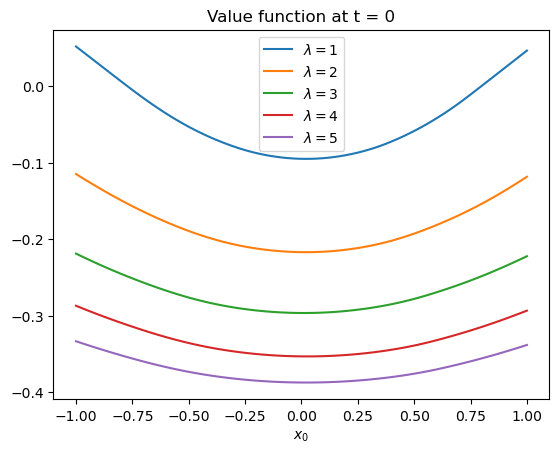

In [124]:
for i in range(5):

    plt.plot(x,value_funcs[i].detach().numpy())

plt.legend([r"$\lambda = 1$",r"$\lambda = 2$", r"$\lambda = 3$",r"$\lambda = 4$",r"$\lambda = 5$"])
plt.title(r"Value function at t = 0")
plt.xlabel(r"$x_0$")